# Generieke template inladen object detection datasets

*This notebook is made to run inside Google colab or the [pxl_ML_Docker_v2.0_Tensorflow](https://github.com/PXLAIRobotics/PXL_ML_Docker_v2.0_TensorFlow) container.*

## Instalations

### HuggingFace

In [1]:
!pip install datasets
!pip install opendatasets

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for opendatasets from https://files.pythonhosted.org/packages/00/e7/12300c2f886b846375c78a4f32c0ae1cd20bdcf305b5ac45b8d7eceda3ec/opendatasets-0.1.22-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 2.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for python-slugify from https://files.pythonhosted.org/packages/a4/62/02da182e544a51a5c3ccf4b03ab79df279f9c60c5e82d5e8bec7ca26ac11/python_slugify-8.0.4-py2.py3-none-any.whl.metadata
  Obtaining dependency information for text-unidecode>=1.3 from https://files.pythonhosted.org/packages/a6/a5/c0b6468d3824fe3fde30dbb5e1f687b291608f9473681bbf7dabbf5

### Restart
Now restart the jupyter (not the container!)

#### Login to HuggingFace by token

In [1]:
from huggingface_hub import notebook_login
notebook_login()

### Kaggle

In [1]:
!pip install kaggle

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


#### Kaggle token
  
Please get your kaggle.json file from kaggle and place it in:
*For container:*  
'notebooks'-folder  
  
*For Google colab:*  
'contents'-folder  

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Roboflow

In [2]:
!pip install roboflow

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for roboflow from https://files.pythonhosted.org/packages/f5/ba/205fb5318ad28c00825bf558bd6565822a1f1fb95305faa5ae52c77bf033/roboflow-1.1.24-py3-none-any.whl.metadata
  Obtaining dependency information for chardet==4.0.0 from https://files.pythonhosted.org/packages/19/c7/fa589626997dd07bd87d9269342ccb74b1720384a4d739a1872bd84fbe68/chardet-4.0.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for cycler==0.10.0 from https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for idna==2.10 from https://files.pythonhosted.org/packages/a2/38/928ddce2273eaa564f6f50de919327bf3a00f091b5baba8dfa9460f3a8a8/idna-2.10-py2.py3-none-any.whl.metadata
  Obtaining dependency information for opencv-python-headless==4.8.0.74 from https://files.pythonh

## Imports

In [23]:
import os
import io
import cv2
import random
import glob
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from datasets import load_dataset
from opendatasets import download as load_opendataset
from roboflow import Roboflow
from PIL import Image
from pathlib import Path
import xml.etree.ElementTree as ET

## algemene code

In [2]:
class Generic_dataset_analysis:
  def __init__(self):
    raise RuntimeError("Not required to create an instance of this class. This class only has static functions.")

  @staticmethod
  def _add_single_folders_to_path(path):    #internal function. if a download contains nested single folders, they get added to the path before copy.
    directory = Path(path)
    folder_content = sorted(directory.iterdir())
    while (len(folder_content) == 1):
      path += '/' + folder_content[0].name
      directory = Path(path)
      folder_content = sorted(directory.iterdir())
    return path
  
  @staticmethod
  def _load_xml_file(filepath):
    xml_file_tree = ET.parse(filepath)
    xml_file = xml_file_tree.getroot()
    data = []
    for object in xml_file.findall('.//object'):
      object_data = {}
      
      def gather_data(elem, path=''):
          for child in elem:
              new_path = path + child.tag + '_'
              if len(child) > 0:
                  gather_data(child, new_path)
              else:
                  object_data[new_path[:-1]] = child.text

      gather_data(object)
      data.append(object_data)
    return data

  @staticmethod
  def _load_yolo_txt_file(filepath):
    with open(filepath, 'r') as file:
      boxes = []
      lines = file.readlines()   
      for line in lines:
        split_line = line.split(" ")
        box_class = split_line.pop(0)

        poly = []
        if len(split_line) > 4:
          for i in range(1, len(split_line), 2):
            poly.append([split_line[i-1], split_line[i]])
          boxes.append({"name": box_class, "poly": poly})
        else:
          boxes.append({"name": box_class, "centerNSize": split_line})
      return boxes
      


  @staticmethod
  def load_object_detection_dataset_from_url(url, image_folder_name=None, label_folder_name=None, dataset_name=None, size=None):

    if not os.path.exists("dataset/"):
      os.makedirs("dataset/")
    elif len(os.listdir("dataset/")) > 0:
      raise RuntimeError("'dataset' folder not empty. Please delete all files first by running the 'remove_dataset()' function of this class.")
    
    split_url = url.split("/")

    if(split_url[2] == "huggingface.co"):
      if(size != None):
        datasets = load_dataset(split_url[-2] + "/" + split_url[-1], size)
      else:
        datasets = load_dataset(split_url[-2] + "/" + split_url[-1])
      dataframes_map = {split: datasets[split].to_pandas() for split in datasets.keys()}
      for key in list(dataframes_map.keys()):

        image_counter = 0
        friendly_key = key
        if(key[0:2] == "te"):
          friendly_key = "test"
        elif(key[0:2] == "tr"):
          friendly_key = "train"
        elif(key[0:2] == "va"):
          friendly_key = "validation"
  
        for index, row in dataframes_map.get(key).iterrows():
          path = "./dataset/{}/".format(friendly_key)
          binary_data = row['image'].get('bytes', None)
          path_image = row['image'].get('path', None)
          if binary_data:
            stream = io.BytesIO(binary_data)
            image = Image.open(stream)
          elif path_image:
            image = Image.open(path_image)
          else:
            raise RuntimeError("Image is not supported. No binary or path keys")
          if not os.path.exists(path):
            os.makedirs(path)
          image_path = "{}{}.png".format(path, image_counter)
          image.save(image_path)
          image_counter += 1

          dataframes_map[key].at[index, 'path'] = image_path
        
      return dataframes_map

    elif (split_url[2] == "www.kaggle.com"):
      if (image_folder_name == None or label_folder_name == None):
        raise RuntimeError("Kaggle URL's need the 'image_folder_name' && 'label_folder_name' to work. They can be the same.")

      link = " " + split_url[-2] + "/" + split_url[-1]
      unzip = split_url[-1]

      load_opendataset(url)
      download_path = Generic_dataset_analysis._add_single_folders_to_path(split_url[-1])
      stream = os.popen('cp -r ' + download_path + '/* dataset/')
      stream.close()

      dataframes_map = {}
      
      directory = Path("dataset/")
      no_sub_dir = False
      if any(image_folder_name == child.name for child in directory.iterdir() if child.is_dir()):
        dataframes_map["all"] = None
        no_sub_dir = True
      else:
        for item in directory.iterdir():
          if item.is_dir():
            dataframes_map[item.name] = None
            if item.name[0:2] == "te":
              os.replace("dataset/" + item.name, "dataset/test")
            elif item.name[0:2] == "tr":
              os.replace("dataset/" + item.name, "dataset/train")
            elif item.name[0:2] == "va":
              os.replace("dataset/" + item.name, "dataset/validation")

      for key in dataframes_map.keys():
        if (no_sub_dir):
          label_directory = Path("dataset/{}".format(label_folder_name))
          image_directory_path = "dataset/{}".format(image_folder_name)
        else:
          label_directory = Path("dataset/{}/{}".format(key, label_folder_name))
          image_directory_path = "dataset/{}/{}".format(key, image_folder_name)
        
        rows = []
        for item in label_directory.iterdir():
          if (item.suffix.lower() in ['.xml']):
            row = {}
            label_path = "{}/{}".format(label_directory, item.name)
            data = Generic_dataset_analysis._load_xml_file(label_path)
            image_path = "./{}/{}*".format(image_directory_path, item.name.split(".")[0])
            matching_files = glob.glob(image_path)
            for file in matching_files:
              file_type = file.split(".")[-1].lower()
              if file_type in ["jpg", "jpeg", "png", "gif"]:
                image_path = file
                break
            if not "*" in image_path:
              row["path"] = image_path
              row["objects"] = data
              rows.append(row)
        df = pd.DataFrame(rows)
        dataframes_map[key] = df    
        
      return dataframes_map

    elif (split_url[2] == "universe.roboflow.com"):
        rf = Roboflow(api_key="ztqwE4dHiRlu1JJrVnLE")
        project = rf.workspace(split_url[3]).project(split_url[4])
        all_versions = project.versions()

        latest_version = all_versions[0].version
        dataset = project.version(latest_version).download("yolov5")

        if dataset_name == None:
          dataset_name = split_url[4]
        dataset_folder_name = dataset_name + '-' + latest_version
        download_dir = Path("./")
        for item in download_dir.iterdir():
          if (item.is_dir() and item.name.lower() == dataset_folder_name.lower() and item.name != dataset_folder_name): #check on case differences
            os.replace(item.name, dataset_folder_name)

        stream = os.popen('cp -r ' + dataset_folder_name + '/* dataset/')
        stream.close()

        directory = Path("dataset/")
        for item in directory.iterdir():
          if item.is_dir() and item.name[0:2] == "te":
            os.replace("dataset/" + item.name, "dataset/test")
          elif item.is_dir() and item.name[0:2] == "tr":
            os.replace("dataset/" + item.name, "dataset/train")
          elif item.is_dir() and item.name[0:2] == "va":
            os.replace("dataset/" + item.name, "dataset/validation")

        dataframes_map = {}
        for key in directory.iterdir():
          if key.is_dir():
            label_directory = Path("dataset/{}/labels".format(key.name))
            image_directory_path = "dataset/{}/images".format(key.name)

            rows = []
            for item in label_directory.iterdir():
              if (item.suffix.lower() in ['.txt']):
                row = {}
                label_path = "{}/{}".format(label_directory, item.name)
                data = Generic_dataset_analysis._load_yolo_txt_file(label_path)
                image_path = "{}/{}*".format(image_directory_path, item.name.split(".")[0])
                matching_files = glob.glob(image_path)
                for file in matching_files:
                  file_type = file.split(".")[-1].lower()
                  if file_type in ["jpg", "jpeg", "png", "gif"]:
                    image_path = file
                    break
                if not "*" in image_path:
                  row["path"] = image_path
                  row["objects"] = data
                  rows.append(row)
            df = pd.DataFrame(rows)
            dataframes_map[key.name] = df  
        return dataframes_map
        
    else:
      raise RuntimeError("This site is not supported...")
    
  @staticmethod
  def load_segmentation_dataset_as_object_detection_from_url(url, image_folder_name, segmentation_folder_name):
    if not os.path.exists("dataset/"):
      os.makedirs("dataset/")
    elif len(os.listdir("dataset/")) > 0:
      raise RuntimeError("'dataset' folder not empty. Please delete all files first by running the 'remove_dataset()' function of this class.")
  
    split_url = url.split("/")
    if (split_url[2] == "www.kaggle.com"):
      load_opendataset(url)
      download_path = Generic_dataset_analysis._add_single_folders_to_path(split_url[-1])
      stream = os.popen('cp -r ' + download_path + '/* dataset/')
      stream.close()

      dataframes_map = {}
      directory = Path("dataset/")
      no_sub_dir = False
      if any(image_folder_name == child.name for child in directory.iterdir() if child.is_dir()):
        dataframes_map["all"] = None
        no_sub_dir = True
      else:
        for item in directory.iterdir():
          if item.is_dir():
            dataframes_map[item.name] = None
            if item.name[0:2] == "te":
              os.replace("dataset/" + item.name, "dataset/test")
            elif item.name[0:2] == "tr":
              os.replace("dataset/" + item.name, "dataset/train")
            elif item.name[0:2] == "va":
              os.replace("dataset/" + item.name, "dataset/validation")

      for key in dataframes_map.keys():
        if (no_sub_dir):
          segmentation_directory = Path("dataset/{}".format(segmentation_folder_name))
          image_directory_path = "dataset/{}".format(image_folder_name)
        else:
          segmentation_directory = Path("dataset/{}/{}".format(key, segmentation_folder_name))
          image_directory_path = "dataset/{}/{}".format(key, image_folder_name)
        
        rows = []
        for item in segmentation_directory.iterdir():
          if (item.suffix.lower() in [".jpg", ".jpeg", ".png", ".gif"]):
            row = {}
            label_path = "{}/{}".format(segmentation_directory, item.name)
            bounding_boxes = Generic_dataset_analysis._get_boundingboxes_from_segmentation(label_path)
            image_path = "./{}/{}*".format(image_directory_path, item.name.split(".")[0])
            matching_files = glob.glob(image_path)
            for file in matching_files:
              file_type = file.split(".")[-1].lower()
              if file_type in ["jpg", "jpeg", "png", "gif"]:
                image_path = file
                break
            if not "*" in image_path:
              row["path"] = image_path
              row["objects"] = bounding_boxes
              rows.append(row)
        df = pd.DataFrame(rows)
        dataframes_map[key] = df    
        
      return dataframes_map

    else:
      raise RuntimeError("This site is not supported...")


  @staticmethod
  def remove_dataset():   #function to remove the datasets folder.
    stream = os.popen('rm -rf ./dataset/')
    stream.close()

In [1]:
class Generic_display_images():
    def __init__(self):
        raise RuntimeError("Not required to create an instance of this class. This class only has static functions.")
    
    @staticmethod
    def _display_image_with_boxes(path, boxes):
        pass
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        for box in boxes:
            points = np.array([box], np.int32)
            image = cv2.polylines(image, [points], isClosed=True, color=(255,255,0), thickness=2)
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis('off')
        plt.show()

    @staticmethod
    def display_random_image(dataframes_map, subset_name):
        subset = dataframes_map[subset_name]
        index = random.randint(0, len(subset))
        if isinstance(subset.iloc[index].objects, dict):
            keys = list(subset.iloc[index].objects.keys())
            if ("bbox" in keys):
                bounding_boxes = subset.iloc[index].objects.get("bbox")
                boxes = []
                for box in bounding_boxes:
                    tl = [int(box[0]), int(box[1])]
                    tr = [int(box[0] + box[2]), int(box[1])]
                    bl = [int(box[0]), int(box[1] + box[3])]
                    br = [int(box[0] + box[2]), int(box[1] + box[3])]
                    boxes.append([tl, tr, br, bl])
                Generic_display_images._display_image_with_boxes(subset.iloc[index].path, boxes)
        elif isinstance(subset.iloc[index].objects, list):
            points = []
            for object in subset.iloc[index].objects:
                keys = list(object.keys())
                if "poly" in keys:
                    image = cv2.imread(subset.iloc[index].path)
                    image_height, image_width = image.shape[:2]
                    for object in subset.iloc[index].objects:
                        object_points = []
                        for point in object["poly"]:
                            object_points.append([int(float(point[0])*image_width), int(float(point[1])*image_height)])
                        points.append(object_points)
                elif 'centerNSize' in keys:
                    image = cv2.imread(subset.iloc[index].path)
                    image_height, image_width = image.shape[:2]
                    for object in subset.iloc[index].objects:
                        values = []
                        for i in range(1, len(object["centerNSize"]), 2):
                            values.append(float(object["centerNSize"][i-1]) * image_width)
                            values.append(float(object["centerNSize"][i]) * image_height)
                        tl = [int(values[0]-(values[2]/2)), int(values[1]-(values[3]/2))]
                        tr = [int(values[0]+(values[2]/2)), int(values[1]-(values[3]/2))]
                        bl = [int(values[0]-(values[2]/2)), int(values[1]+(values[3]/2))]
                        br = [int(values[0]+(values[2]/2)), int(values[1]+(values[3]/2))]
                        points.append([tl, tr, br, bl])
                elif ('bndbox_xmin' in keys and 'bndbox_ymin' in keys and 'bndbox_xmax' in keys and 'bndbox_ymax' in keys):
                        tl = [int(object['bndbox_xmin']), int(object['bndbox_ymin'])]
                        tr = [int(object['bndbox_xmax']), int(object['bndbox_ymin'])]
                        bl = [int(object['bndbox_xmin']), int(object['bndbox_ymax'])]
                        br = [int(object['bndbox_xmax']), int(object['bndbox_ymax'])]
                        points.append([tl, tr, br, bl])
                else:
                    raise RuntimeError("The type of bounding boxes is not supported")
            Generic_display_images._display_image_with_boxes(subset.iloc[index].path, points)
        else:
            raise RuntimeError("The type of objects is not supported")

### Inladen verschillende data sources

#### Verwijderen van dataset

In [117]:
Generic_dataset_analysis.remove_dataset()

### Huggingface

In [9]:
url = "https://huggingface.co/datasets/Francesco/cotton-plant-disease"
dataframes_map = Generic_dataset_analysis.load_object_detection_dataset_from_url(url)
print(dataframes_map)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value './dataset/train/0.png' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value './dataset/validation/0.png' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value './dataset/test/0.png' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


{'train':      image_id                                              image  width  \
0         646  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    640   
1         394  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    640   
2           5  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    640   
3         533  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    640   
4         445  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    640   
..        ...                                                ...    ...   
719        35  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    640   
720       685  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    640   
721       511  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    640   
722       249  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    640   
723        14  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...    640   

     height                                            objects  \
0       640  {'id': [39

In [11]:
url = "https://huggingface.co/datasets/keremberke/german-traffic-sign-detection"
dataframes_map = Generic_dataset_analysis.load_object_detection_dataset_from_url(url, size="full")
print(dataframes_map)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value './dataset/train/0.png' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value './dataset/validation/0.png' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value './dataset/test/0.png' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


{'train':      image_id                                              image  width  \
0          47  {'bytes': None, 'path': '/home/user/.cache/hug...   1360   
1         343  {'bytes': None, 'path': '/home/user/.cache/hug...   1360   
2         154  {'bytes': None, 'path': '/home/user/.cache/hug...   1360   
3         375  {'bytes': None, 'path': '/home/user/.cache/hug...   1360   
4         134  {'bytes': None, 'path': '/home/user/.cache/hug...   1360   
..        ...                                                ...    ...   
378        42  {'bytes': None, 'path': '/home/user/.cache/hug...   1360   
379       322  {'bytes': None, 'path': '/home/user/.cache/hug...   1360   
380       356  {'bytes': None, 'path': '/home/user/.cache/hug...   1360   
381       114  {'bytes': None, 'path': '/home/user/.cache/hug...   1360   
382       345  {'bytes': None, 'path': '/home/user/.cache/hug...   1360   

     height                                            objects  \
0       800  {'id': [67

In [216]:
print(dataframes_map["all"].iloc[0].objects)


[{'name': 'kangaroo', 'pose': 'Unspecified', 'truncated': '1', 'difficult': '0', 'bndbox_xmin': '550', 'bndbox_ymin': '154', 'bndbox_xmax': '942', 'bndbox_ymax': '720'}, {'name': 'kangaroo', 'pose': 'Unspecified', 'truncated': '1', 'difficult': '0', 'bndbox_xmin': '82', 'bndbox_ymin': '81', 'bndbox_xmax': '532', 'bndbox_ymax': '720'}]


### Kaggle

In [296]:
url = "https://www.kaggle.com/datasets/chitholian/annotated-potholes-dataset"
dataframes_map = Generic_dataset_analysis.load_object_detection_dataset_from_url(url, "annotated-images", "annotated-images")
dataframes_map

Skipping, found downloaded files in "./annotated-potholes-dataset" (use force=True to force download)


{'all':                                        path  \
 0    ./dataset/annotated-images/img-178.jpg   
 1    ./dataset/annotated-images/img-447.jpg   
 2    ./dataset/annotated-images/img-209.jpg   
 3    ./dataset/annotated-images/img-508.jpg   
 4    ./dataset/annotated-images/img-528.jpg   
 ..                                      ...   
 660  ./dataset/annotated-images/img-605.jpg   
 661  ./dataset/annotated-images/img-574.jpg   
 662  ./dataset/annotated-images/img-278.jpg   
 663  ./dataset/annotated-images/img-369.jpg   
 664  ./dataset/annotated-images/img-598.jpg   
 
                                                objects  
 0    [{'name': 'pothole', 'pose': 'Unspecified', 't...  
 1    [{'name': 'pothole', 'pose': 'Unspecified', 't...  
 2    [{'name': 'pothole', 'pose': 'Unspecified', 't...  
 3    [{'name': 'pothole', 'pose': 'Unspecified', 't...  
 4    [{'name': 'pothole', 'pose': 'Unspecified', 't...  
 ..                                                 ...  
 660  [{'

In [32]:
url = "https://www.kaggle.com/datasets/hugozanini1/kangaroodataset"
dataframes_map = Generic_dataset_analysis.load_object_detection_dataset_from_url(url, "images", "annotations")
print(dataframes_map)

100%|██████████| 72.6M/72.6M [00:03<00:00, 19.5MB/s]



{'all':                                   path  \
0    ./dataset/images/kangaroo-712.jpg   
1    ./dataset/images/kangaroo-214.jpg   
2    ./dataset/images/kangaroo-217.jpg   
3    ./dataset/images/kangaroo-715.jpg   
4    ./dataset/images/kangaroo-117.jpg   
..                                 ...   
319  ./dataset/images/kangaroo-222.jpg   
320  ./dataset/images/kangaroo-393.jpg   
321  ./dataset/images/kangaroo-315.jpg   
322   ./dataset/images/kangaroo-97.jpg   
323  ./dataset/images/kangaroo-250.jpg   

                                               objects  
0    [{'name': 'kangaroo', 'pose': 'Unspecified', '...  
1    [{'name': 'kangaroo', 'pose': 'Unspecified', '...  
2    [{'name': 'kangaroo', 'pose': 'Unspecified', '...  
3    [{'name': 'kangaroo', 'pose': 'Unspecified', '...  
4    [{'name': 'kangaroo', 'pose': 'Unspecified', '...  
..                                                 ...  
319  [{'name': 'kangaroo', 'pose': 'Unspecified', '...  
320  [{'name': 'kangaroo', 'po

### Roboflow

In [68]:
url = "https://universe.roboflow.com/palm-oil-count-detection/oil-palm-count"
dataframes_map = Generic_dataset_analysis.load_object_detection_dataset_from_url(url)
print(dataframes_map)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Oil-Palm-Count-3 in yolov5pytorch:: 100%|██████████| 1064/1064 [00:00<00:00, 4875.58it/s]


{'test':                                                  path  \
0   dataset/test/images/OP-268-_jpg.rf.f8af3b23f1f...   
1   dataset/test/images/OP-345-_jpg.rf.126e4d435fc...   
2   dataset/test/images/OP-270-_jpg.rf.265a59a4f7e...   
3   dataset/test/images/OP-221-_jpg.rf.92a812300c5...   
4   dataset/test/images/OP-302-_jpg.rf.fada3df63d7...   
5   dataset/test/images/OP-219-_jpg.rf.5a98f00c618...   
6   dataset/test/images/OP-193-_jpg.rf.bbdb9a6f441...   
7   dataset/test/images/OP-273-_jpg.rf.fac2ffdd046...   
8   dataset/test/images/OP-310-_jpg.rf.7b9868be64e...   
9   dataset/test/images/OP-247-_jpg.rf.995027ebaa2...   
10  dataset/test/images/OP-211-_jpg.rf.1c420d43c34...   
11  dataset/test/images/OP-303-_jpg.rf.275c2a94a99...   
12  dataset/test/images/OP-78-_jpg.rf.7938a7537bd7...   
13  dataset/test/images/OP-269-_jpg.rf.0a9ae49514d...   
14  dataset/test/images/OP-70-_jpg.rf.4036ec82aea6...   
15  dataset/test/images/OP-69-_jpg.rf.0724750e0d37...   
16  dataset/test/image

In [24]:
ro1 = dataframes_map

In [118]:
url = "https://universe.roboflow.com/wf-jhhnr/food-wpyha"
dataframes_map = Generic_dataset_analysis.load_object_detection_dataset_from_url(url, dataset_name="food")
print(dataframes_map)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Food-3 in yolov5pytorch:: 100%|██████████| 164/164 [00:00<00:00, 9433.55it/s]

{'test':                                                 path  \
0  dataset/test/images/12_jpg.rf.3b2e12e26064df77...   
1  dataset/test/images/22_jpg.rf.122326b1e7d7e763...   

                                             objects  
0  [{'name': '0', 'poly': [['0.5068359375', '0.51...  
1  [{'name': '0', 'poly': [['0.525390625', '0.647...  , 'train':                                                  path  \
0   dataset/train/images/9_jpg.rf.6e96f49ae7a1afa1...   
1   dataset/train/images/33_jpg.rf.d80b34da6d68ee2...   
2   dataset/train/images/20_jpg.rf.9541c6eef79892e...   
3   dataset/train/images/60_jpg.rf.084b3a750933a9b...   
4   dataset/train/images/14_jpg.rf.30e4be564d3fb63...   
..                                                ...   
68  dataset/train/images/77_jpg.rf.16eef125e64081d...   
69  dataset/train/images/35_jpg.rf.f852b92b8125996...   
70  dataset/train/images/75_jpg.rf.01419e117d57a96...   
71  dataset/train/images/92_jpg.rf.2ece8aa1a13d746...   
72  dataset/train/im

In [29]:
ro2 = dataframes_map

## Display images

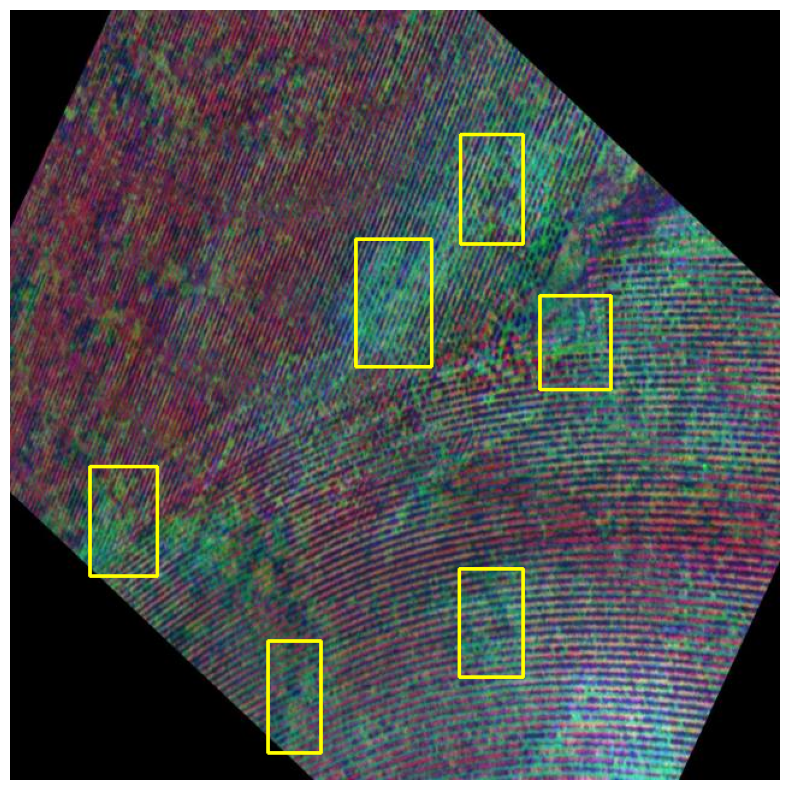

In [353]:
Generic_display_images.display_random_image(dataframes_map, "train")

[[1172, 270], [1237, 270], [1237, 336], [1172, 336]]
[[1264, 368], [1295, 368], [1295, 398], [1264, 398]]


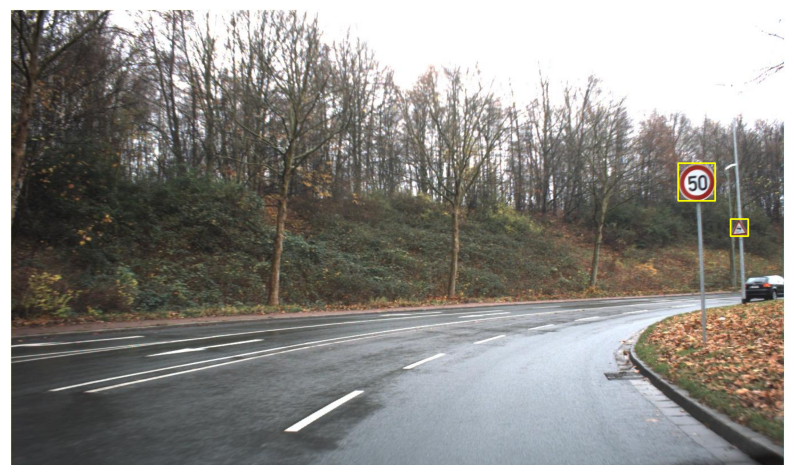

In [29]:
Generic_display_images.display_random_image(dataframes_map, "train")

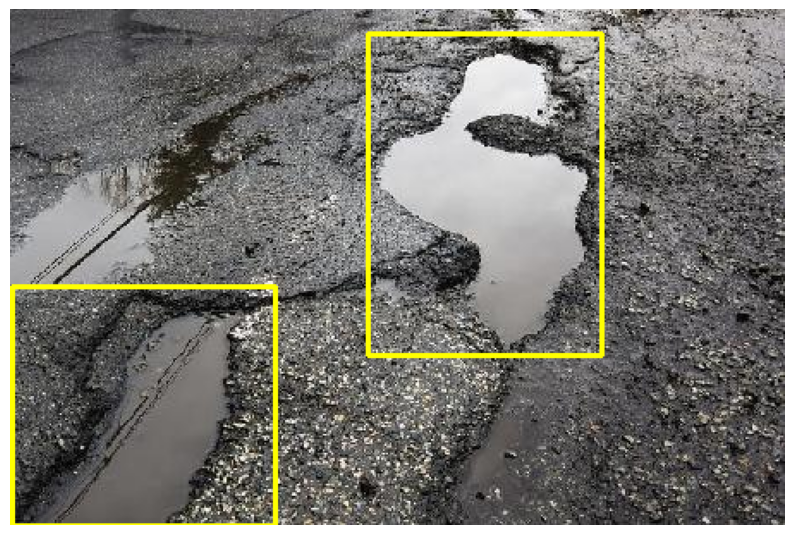

In [339]:
Generic_display_images.display_random_image(dataframes_map, "all")

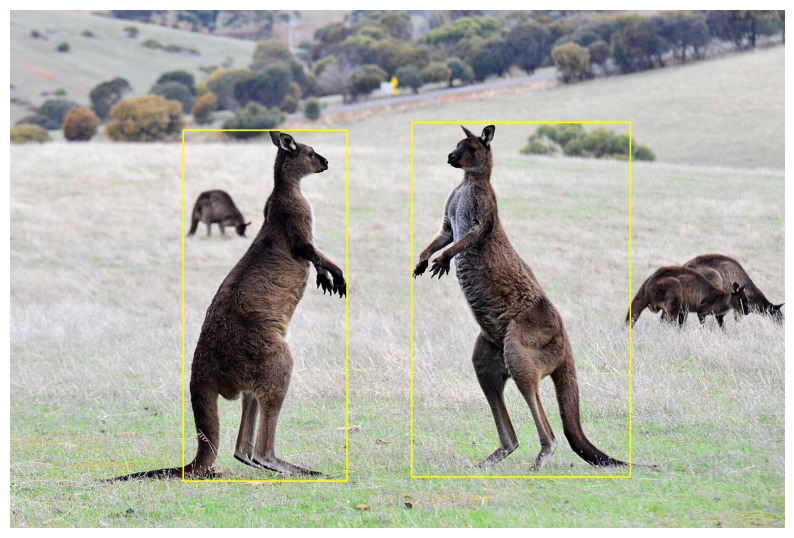

In [37]:
Generic_display_images.display_random_image(dataframes_map, "all")

In [116]:
Generic_display_images.display_random_image(dataframes_map, "train")

In [131]:
Generic_display_images.display_random_image(dataframes_map, "train")